<a href="https://colab.research.google.com/github/vaibhav670/Digital-Clock-Web-Application/blob/main/Copy_of_Deep_Learning_with_PyTorch_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM - Gradient Class Activation Map

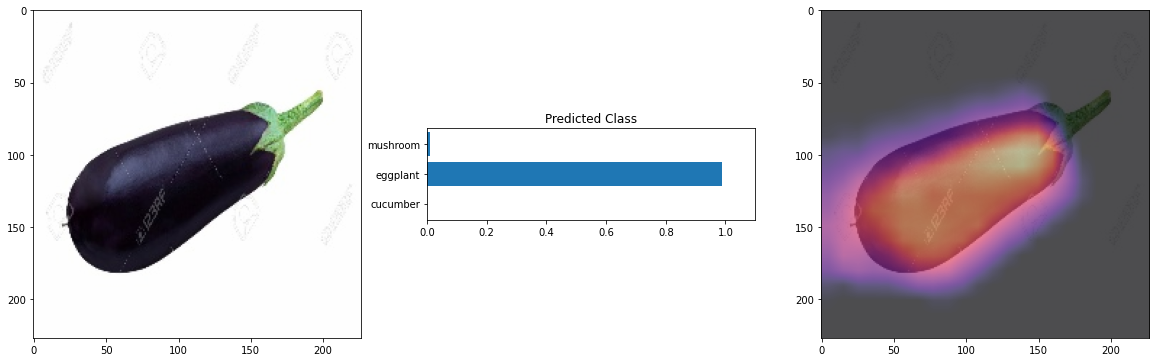

In [2]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 1.09 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1v_4ooq2
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1v_4ooq2
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Imports

In [3]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [5]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda'
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 16

In [6]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [7]:


#cucumber = 1,eggplant - 2,mushroom = 3

train_df,valid_df = train_test_split(data,test_size=0.2,random_state = 42)

# Augmentations

In [8]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485,0.456,0.406],std=[0.299,0.244,0.255])
])

valid_augs = A.Compose([
     A.Normalize(mean=[0.485,0.456,0.406],std=[0.299,0.244,0.255])
])

# Load Image Dataset

In [9]:
trainset=utils.ImageDataset(train_df,augs = train_augs,data_dir=DATA_DIR)
validset=utils.ImageDataset(valid_df,augs = valid_augs,data_dir=DATA_DIR)

Text(0.5, 1.0, 'mushroom')

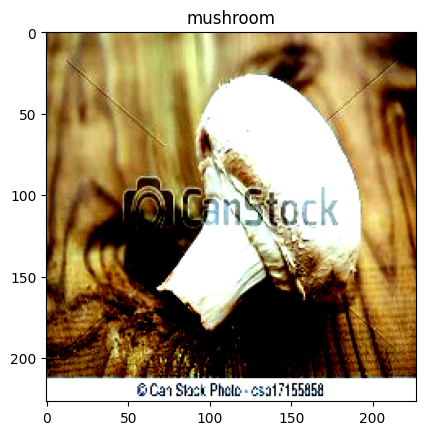

In [10]:
image,label = validset[23] #(c,h,w) ->(h,w,c)
class_list = ['cucumber','eggplant','mushroom']

plt.imshow(image.permute(1,2,0))
plt.title(class_list[label])

In [11]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [12]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE,shuffle = True )
validloader = DataLoader(validset,batch_size = BATCH_SIZE, )

In [13]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [14]:
for images,labels in trainloader :
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

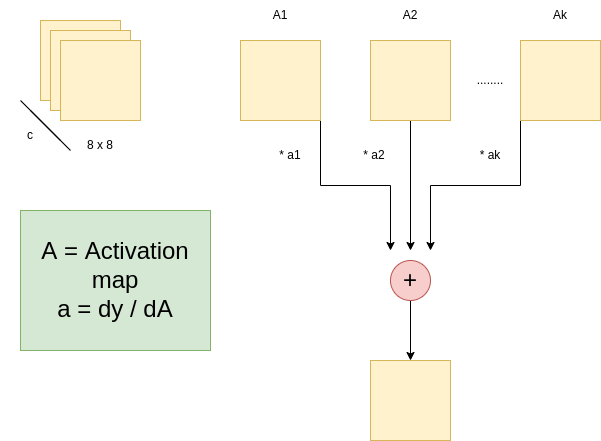

In [90]:
class ImageModel(nn.Module):

    def __init__(self):
        super(ImageModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
            nn.ReLU()
        )

        self.maxpool = nn.MaxPool2d(kernel_size= (4,4), stride = 2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),  # Adjusted input size to match the output of the feature extractor
            nn.ReLU(),
            nn.Linear(2048, 3)
        )

        self.gradient = None

    def activations_hook(self, grad):
        self.gradient = grad

    def forward(self, images):
        x = self.feature_extractor(images)  # Activation maps
        h = x.register_hook(self.activations_hook)
        x = self.maxpool(x)
        x = self.classifier(x)

        return x

    def get_activation_gradients(self): #a1,a2
        return self.gradient

    def get_activation(self, x):
        return self.feature_extractor(x) #A1.A2


In [91]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [92]:
def train_fn(dataloader,model,optimizer,criterion):

    model.train()
    total_loss = 0.0
    for images,labels in tqdm (dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad ()
        logits = model (images)
        loss = criterion(logits,labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [93]:
def eval_fn(dataloader,model,criterion):

    model.eval()
    total_loss = 0.0
    for images,labels in tqdm (dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)


        logits = model (images)
        loss = criterion(logits,labels)


        total_loss += loss.item()

    return total_loss / len(dataloader)


# Training Loop

In [94]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)
criterion = torch.nn.CrossEntropyLoss()

In [95]:
import numpy as np
import torch

best_valid_loss = np.Inf

# Assuming you have defined your model architecture somewhere
 # Adjust input_size according to your data

for i in range(EPOCHS):


    train_loss = train_fn(trainloader, model, optimizer, criterion)
    valid_loss = eval_fn(validloader, model, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_weights.pt')
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")

    print(f"EPOCH: {i+1} TRAIN LOSS: {train_loss} VALID LOSS: {valid_loss}")


100%|██████████| 3/3 [00:00<00:00, 36.50it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 1 TRAIN LOSS: 1.1304177641868591 VALID LOSS: 1.0531949599583943


100%|██████████| 3/3 [00:00<00:00, 38.83it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 2 TRAIN LOSS: 0.8192704141139984 VALID LOSS: 0.7990444203217825


100%|██████████| 3/3 [00:00<00:00, 39.48it/s]


EPOCH: 3 TRAIN LOSS: 0.4606267295777798 VALID LOSS: 0.9370914647976557


100%|██████████| 3/3 [00:00<00:00, 37.91it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 4 TRAIN LOSS: 0.4288230471313 VALID LOSS: 0.3174770151575406


100%|██████████| 3/3 [00:00<00:00, 38.36it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 5 TRAIN LOSS: 0.1886989116668701 VALID LOSS: 0.1764565253009399


100%|██████████| 3/3 [00:00<00:00, 40.75it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 6 TRAIN LOSS: 0.23505184343084692 VALID LOSS: 0.1680926469465097


100%|██████████| 3/3 [00:00<00:00, 38.03it/s]


EPOCH: 7 TRAIN LOSS: 0.4126821294426918 VALID LOSS: 0.3274693936109543


100%|██████████| 3/3 [00:00<00:00, 38.94it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 8 TRAIN LOSS: 0.2039324827492237 VALID LOSS: 0.11006250356634457


100%|██████████| 3/3 [00:00<00:00, 38.79it/s]


EPOCH: 9 TRAIN LOSS: 0.1074582819128409 VALID LOSS: 0.3432988761924207


100%|██████████| 3/3 [00:00<00:00, 41.03it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 10 TRAIN LOSS: 0.19344552047550678 VALID LOSS: 0.10254969944556554


100%|██████████| 3/3 [00:00<00:00, 41.21it/s]


EPOCH: 11 TRAIN LOSS: 0.311332393437624 VALID LOSS: 0.13493437319993973


100%|██████████| 3/3 [00:00<00:00, 40.70it/s]


EPOCH: 12 TRAIN LOSS: 0.10418537659570574 VALID LOSS: 0.14708189914623895


100%|██████████| 3/3 [00:00<00:00, 40.08it/s]


EPOCH: 13 TRAIN LOSS: 0.07779944630456156 VALID LOSS: 0.18404259563734135


100%|██████████| 3/3 [00:00<00:00, 37.84it/s]


EPOCH: 14 TRAIN LOSS: 0.07783886031247675 VALID LOSS: 0.1496401239807407


100%|██████████| 3/3 [00:00<00:00, 25.74it/s]


EPOCH: 15 TRAIN LOSS: 0.0319239255040884 VALID LOSS: 0.14686780981719494


100%|██████████| 3/3 [00:00<00:00, 23.43it/s]

EPOCH: 16 TRAIN LOSS: 0.0640117897070013 VALID LOSS: 0.31442563111583394


# Get GradCAM

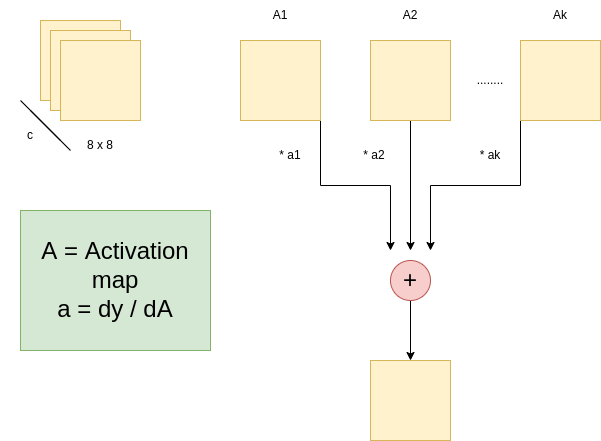

In [105]:
def get_gradcam (model,image,label,size):
    label.backward()
    gradients = model.get_activation_gradients()
    pooled_gradients = torch.mean(gradients,dim=[0,2,3]) #a1,a2
    activations = model.get_activation(image).detach() #A1,A2

    for i in range (activations.shape[1]):
        activations[:,1,:,:]  *=pooled_gradients [i]

    heatmap = torch.mean(activations,dim=1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap/= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(),(size,size))

    return heatmap


In [ ]:
#cucumber - 0, eggplant - 1,mushroom-2

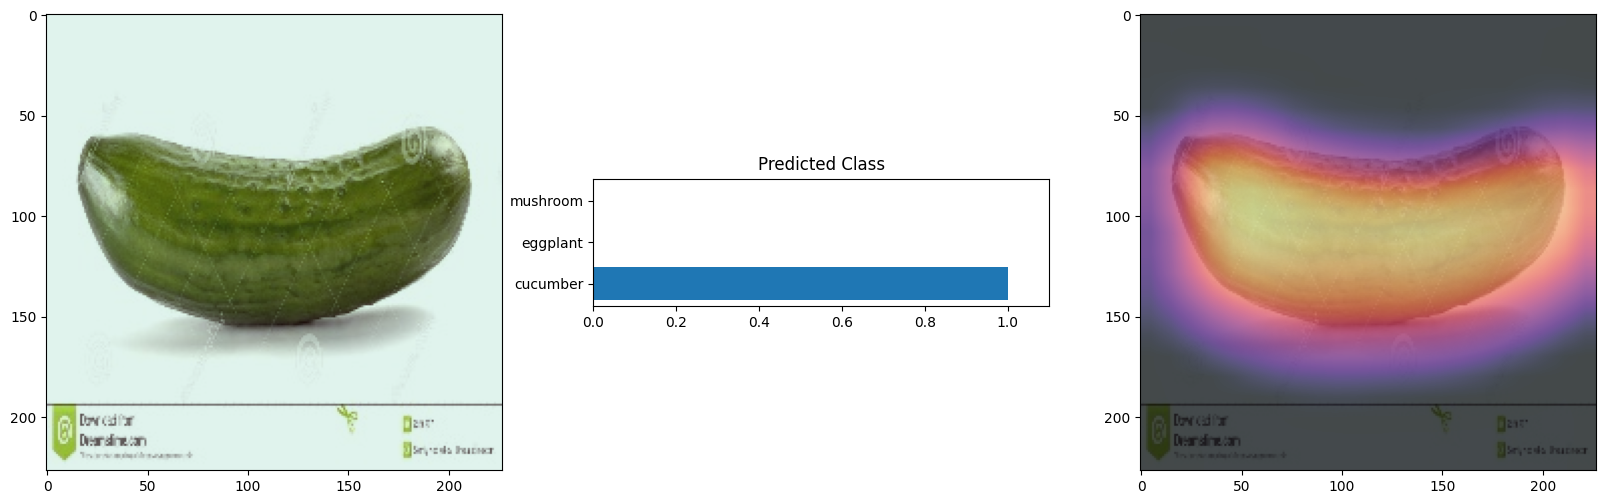

In [120]:
image,label = validset[16]
denorm_image = image.permute(1,2,0)*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model,image,pred[0][0],size=227)
utils.plot_heatmap(denorm_image,pred,heatmap)
